In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from datetime import datetime, time
import seaborn as sns

In [3]:
from data.subjects_to_keep import subjects_to_keep as users
from data.data_path import data_path

In [4]:
for u in users:  
    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]
    
    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
    df.dt = df.dt.dt.tz_convert('Europe/London')
    
    all_pos = df.step_midnight.values
    
    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestep = (np.asarray([(dt - datetime.combine(dt, time.min, dt.tz)).total_seconds() for dt in df.dt]) / 86400)  # in fraction of day (between 0 and 1)
    
    all_x = [[] for _ in range(uniq_days.size)]
    
    for idx_day, day in enumerate(uniq_days):
        
        is_day = days == day
        obs_timestep, obs_pos = all_timestep[is_day], all_pos[is_day]
        
        diff_obs_pos = np.diff(obs_pos)

        assert np.all(np.arange(obs_timestep.size) == np.argsort(obs_timestep)), "Not sorted"
        
        for ts, diff in zip(obs_timestep, diff_obs_pos):
            all_x[idx_day] += [ts for _ in range(diff)]  # Probably want to spread that over a period assuming something like 6000 steps per hour
    break


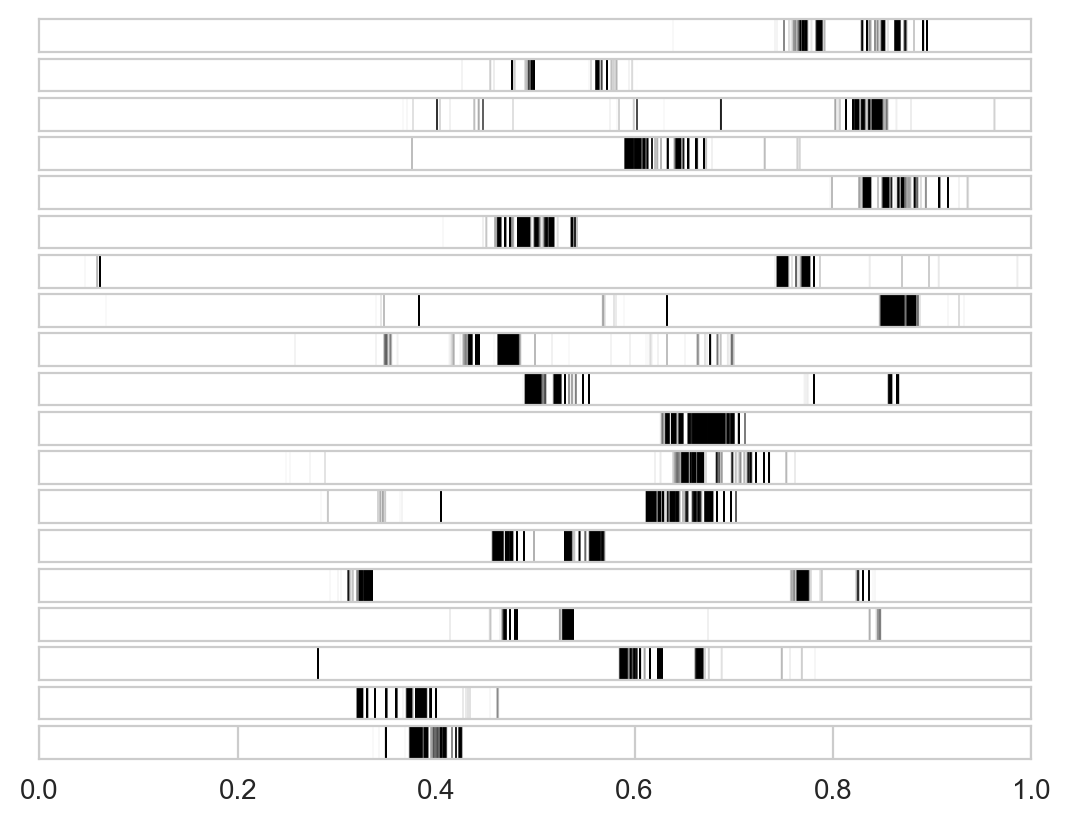

In [5]:
fig, axes = plt.subplots(nrows=len(uniq_days))
for idx_day, day in enumerate(uniq_days):
    ax = axes[idx_day]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if day != uniq_days[-1]:
        ax.set_xticks([])
    ax.set_yticks([])
    for a_ in all_x[idx_day]:
        ax.vlines(a_, 0, 1, color="k", lw=0.1, alpha=0.02)

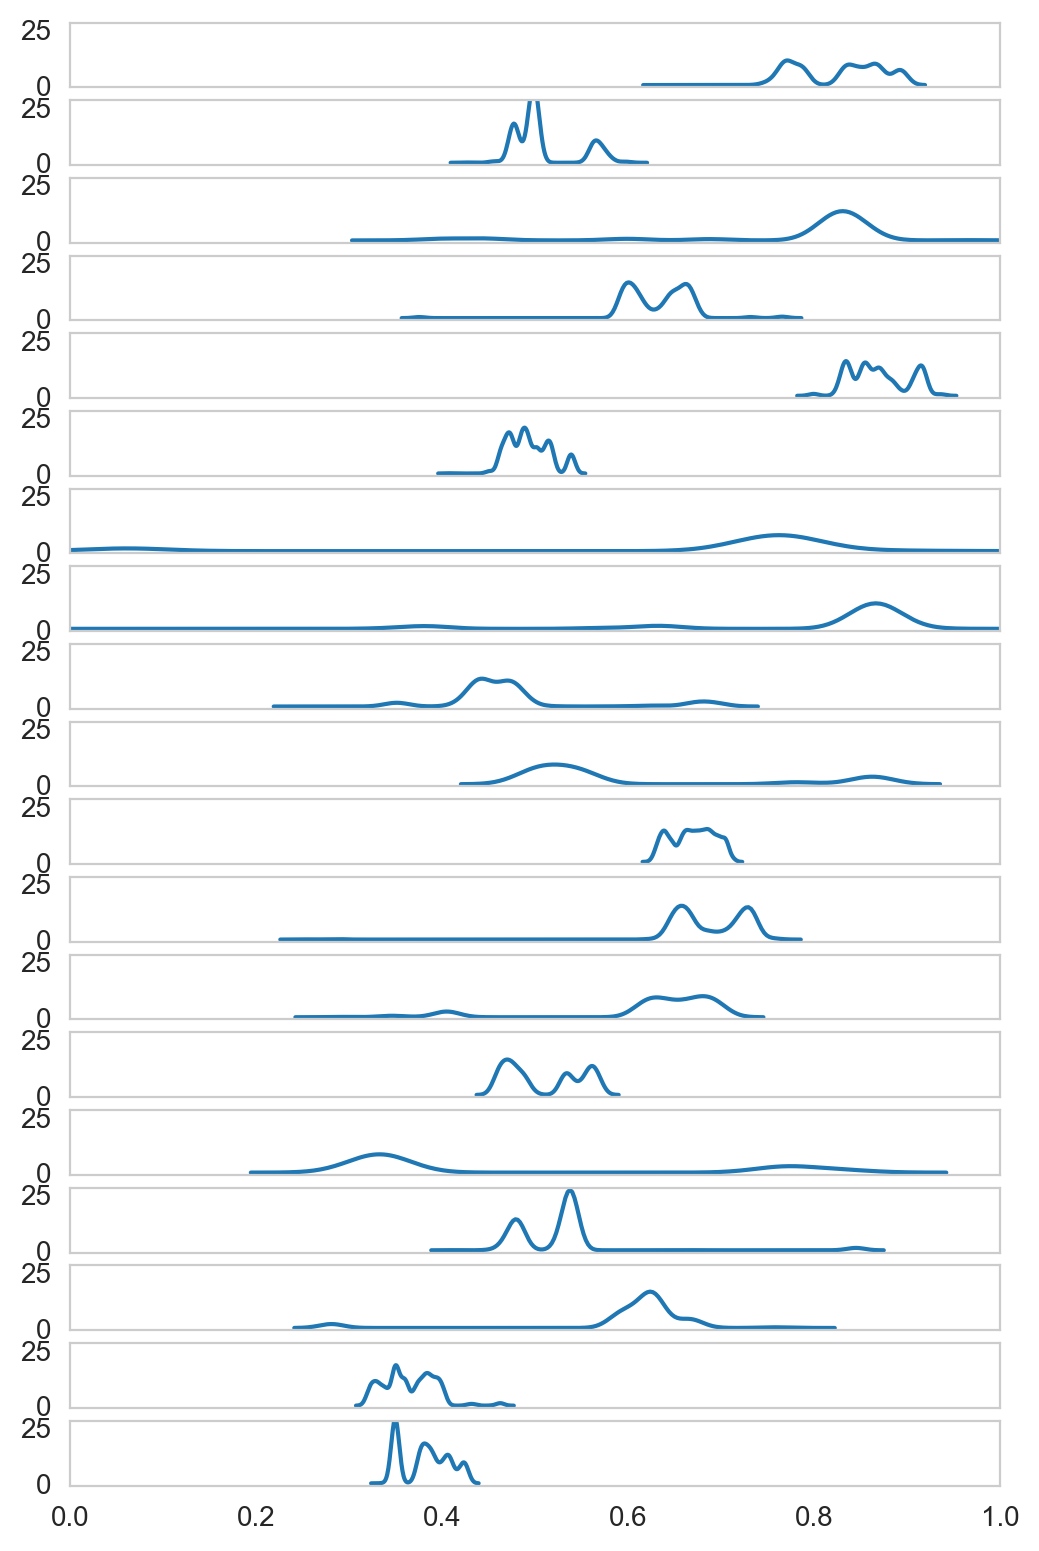

In [6]:
fig, axes = plt.subplots(nrows=len(uniq_days), figsize=(6, len(uniq_days)*0.5))
for idx_day, day in enumerate(uniq_days):
    ax = axes[idx_day]
    sns.kdeplot(all_x[idx_day], ax=ax)
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 28)
    ax.set_ylabel("")
    ax.grid(False)
    if day != uniq_days[-1]:
        ax.set_xticks([])

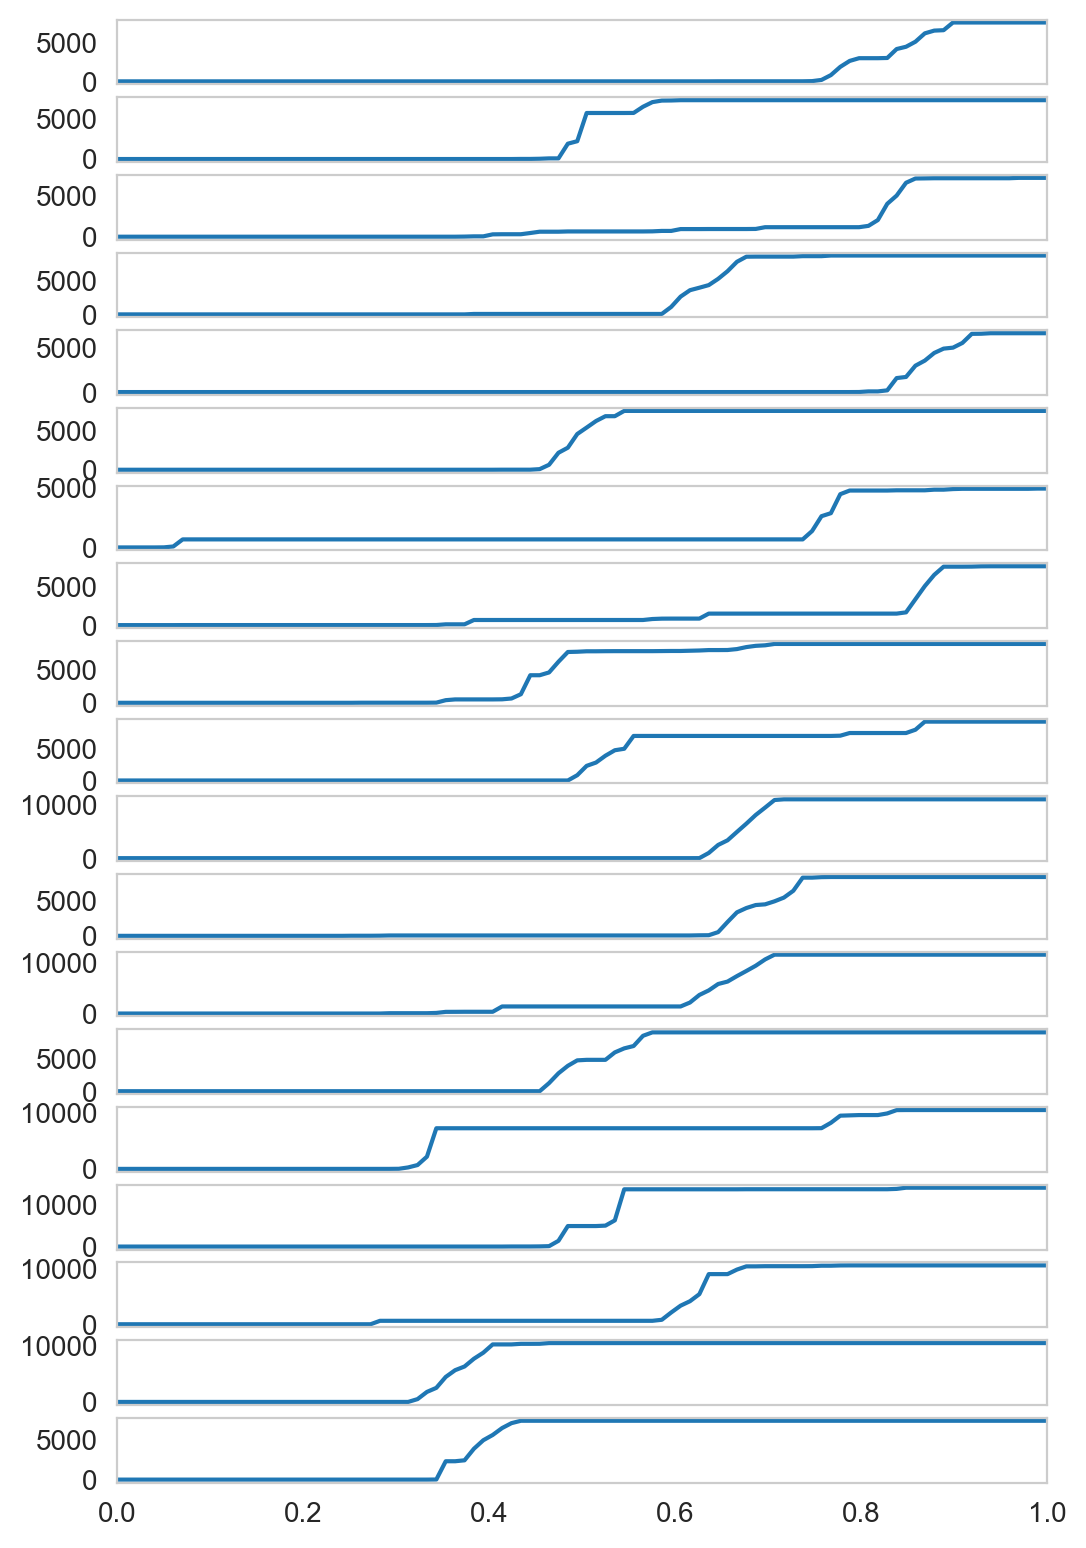

In [7]:
x = np.linspace(0, 1, 100)
fig, axes = plt.subplots(nrows=len(uniq_days), figsize=(6, len(uniq_days) * 0.5))
for idx_day, day in enumerate(uniq_days):
    ax = axes[idx_day]
    a = all_x[idx_day]
    y = np.sum(a <= x[:, None], axis=1)
    
    ax.plot(x, y)
    ax.set_xlim(0, 1)
    # ax.set_ylim(-1, 28)
    ax.set_ylabel("")
    ax.grid(False)
    if day != uniq_days[-1]:
        ax.set_xticks([])

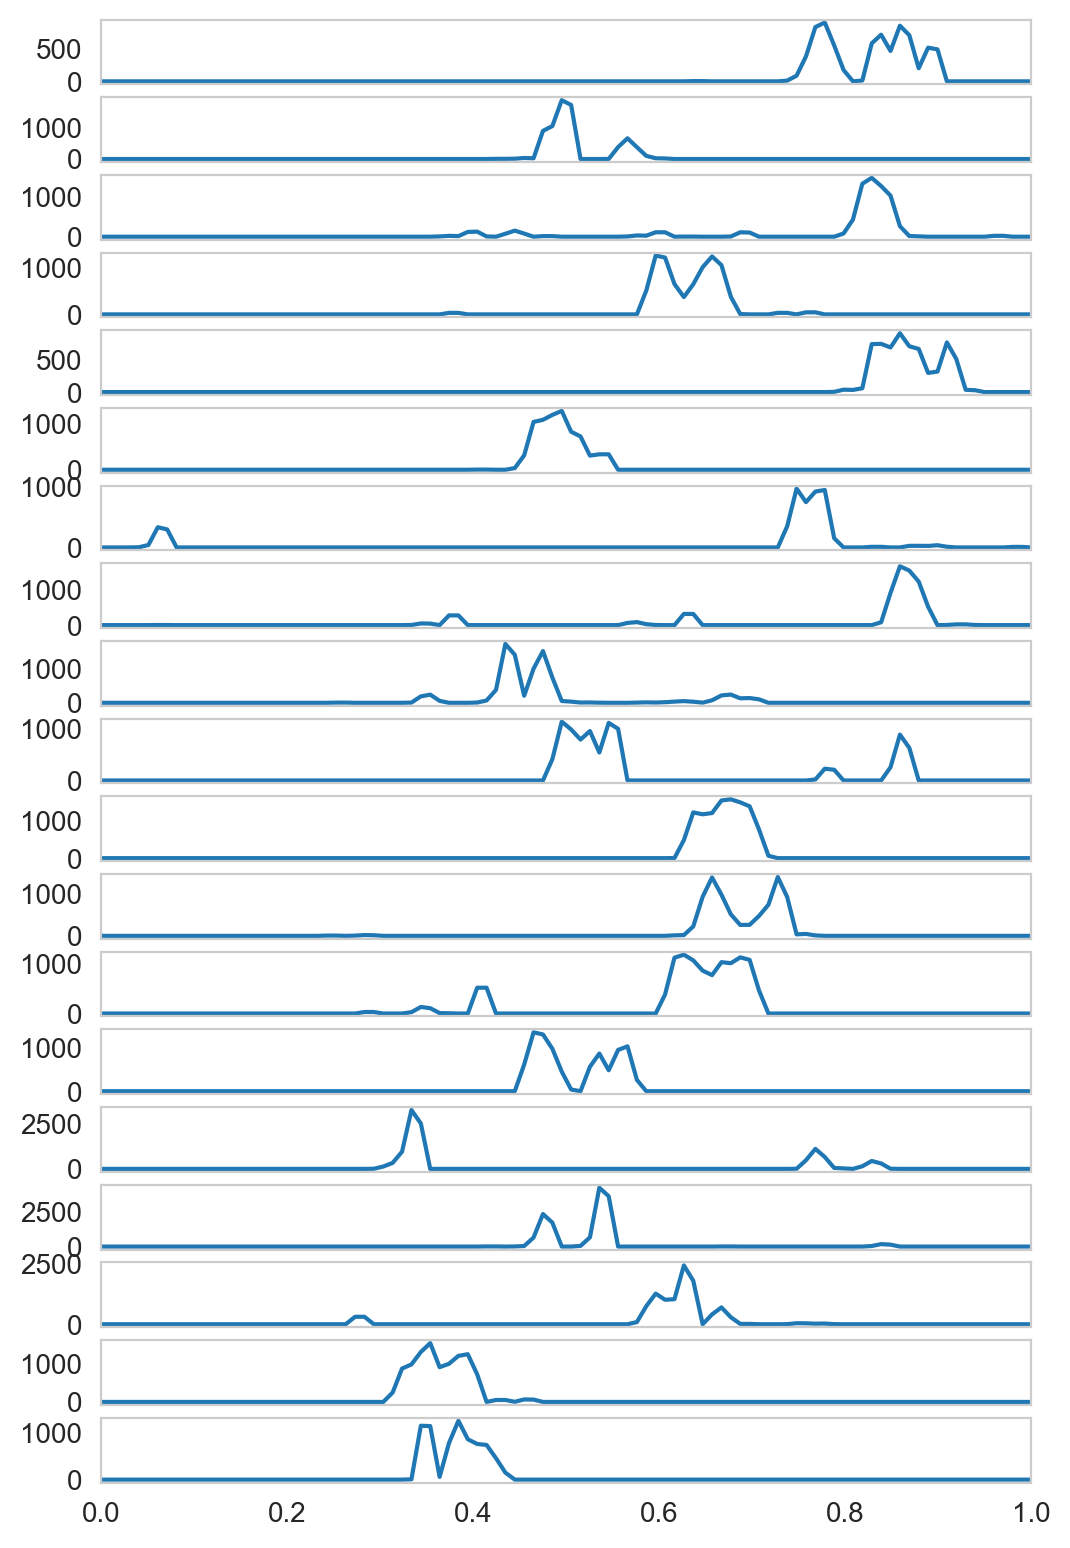

In [8]:
timestep = np.linspace(0, 1, 100)
fig, axes = plt.subplots(nrows=len(uniq_days), figsize=(6, len(uniq_days) * 0.5))
for idx_day, day in enumerate(uniq_days):
    ax = axes[idx_day]
    x = all_x[idx_day]
    cum_x = np.sum(x <= timestep[:, None], axis=1)
    deriv = np.gradient(cum_x, timestep) / timestep.size
    
    ax.plot(timestep, deriv)
    ax.set_xlim(0, 1)
    # ax.set_ylim(-1, 28)
    ax.set_ylabel("")
    ax.grid(False)
    if day != uniq_days[-1]:
        ax.set_xticks([])

In [9]:
timestep = np.linspace(0, 1, 100)
for idx_day, day in enumerate(uniq_days):
    ax = axes[idx_day]
    x = all_x[idx_day]
    cum_x = np.sum(x <= timestep[:, None], axis=1)
    deriv = np.gradient(cum_x, timestep) / timestep.size
    print(f"sum deriv {deriv.sum():.2f}, actual step number {len(a)}")

sum deriv 7426.98, actual step number 7429
sum deriv 7244.82, actual step number 7429
sum deriv 7065.63, actual step number 7429
sum deriv 8502.12, actual step number 7429
sum deriv 6585.48, actual step number 7429
sum deriv 7520.04, actual step number 7429
sum deriv 4889.61, actual step number 7429
sum deriv 7476.48, actual step number 7429
sum deriv 8643.69, actual step number 7429
sum deriv 9140.67, actual step number 7429
sum deriv 10814.76, actual step number 7429
sum deriv 8156.61, actual step number 7429
sum deriv 11389.95, actual step number 7429
sum deriv 8801.10, actual step number 7429
sum deriv 10293.03, actual step number 7429
sum deriv 13728.33, actual step number 7429
sum deriv 10457.37, actual step number 7429
sum deriv 10286.10, actual step number 7429
sum deriv 7354.71, actual step number 7429


In [10]:
timestep = np.linspace(0, 1, 10)

deriv_list = []
n_days = len(all_x)

for idx_day in range(n_days):
    x = all_x[idx_day]
    cum_x = np.sum(x <= timestep[:, None], axis=1)
    deriv = np.gradient(cum_x, timestep) / timestep.size
    deriv_list.append(deriv)

<Axes: ylabel='Density'>

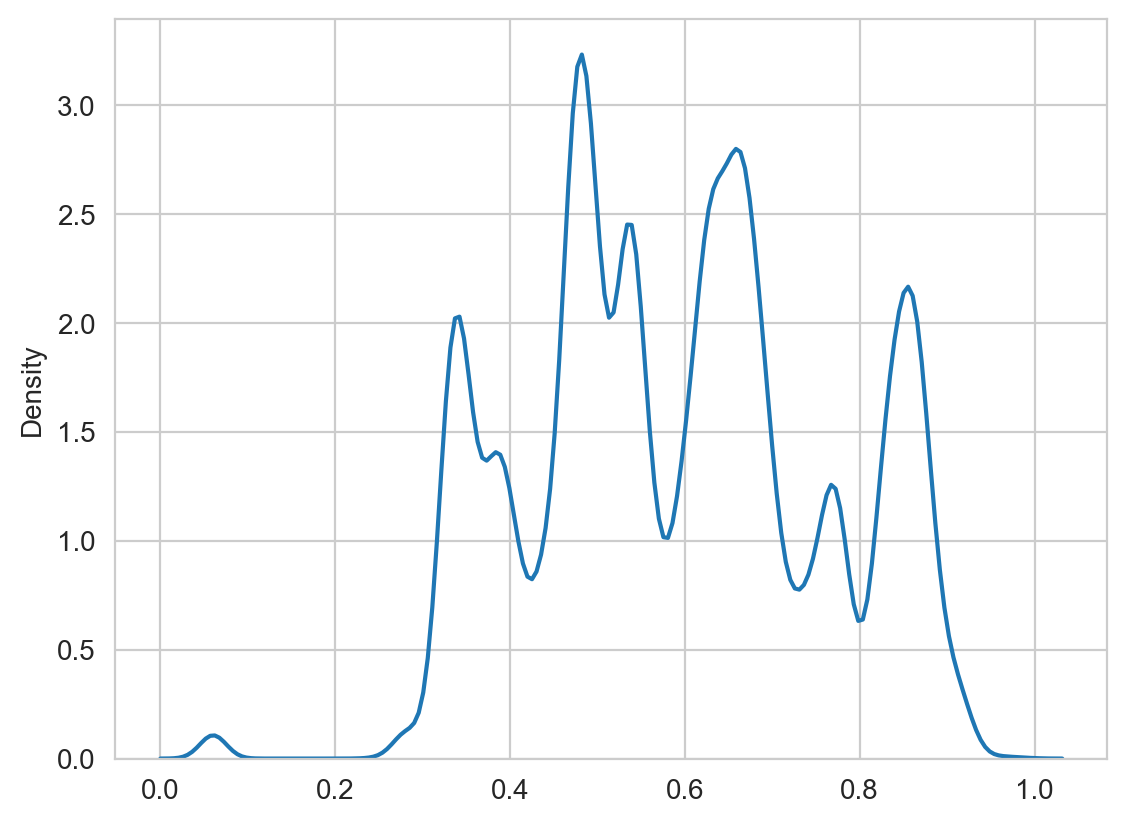

In [11]:
fig, ax = plt.subplots()
sns.kdeplot(np.concatenate(all_x), ax=ax)

<Axes: ylabel='Density'>

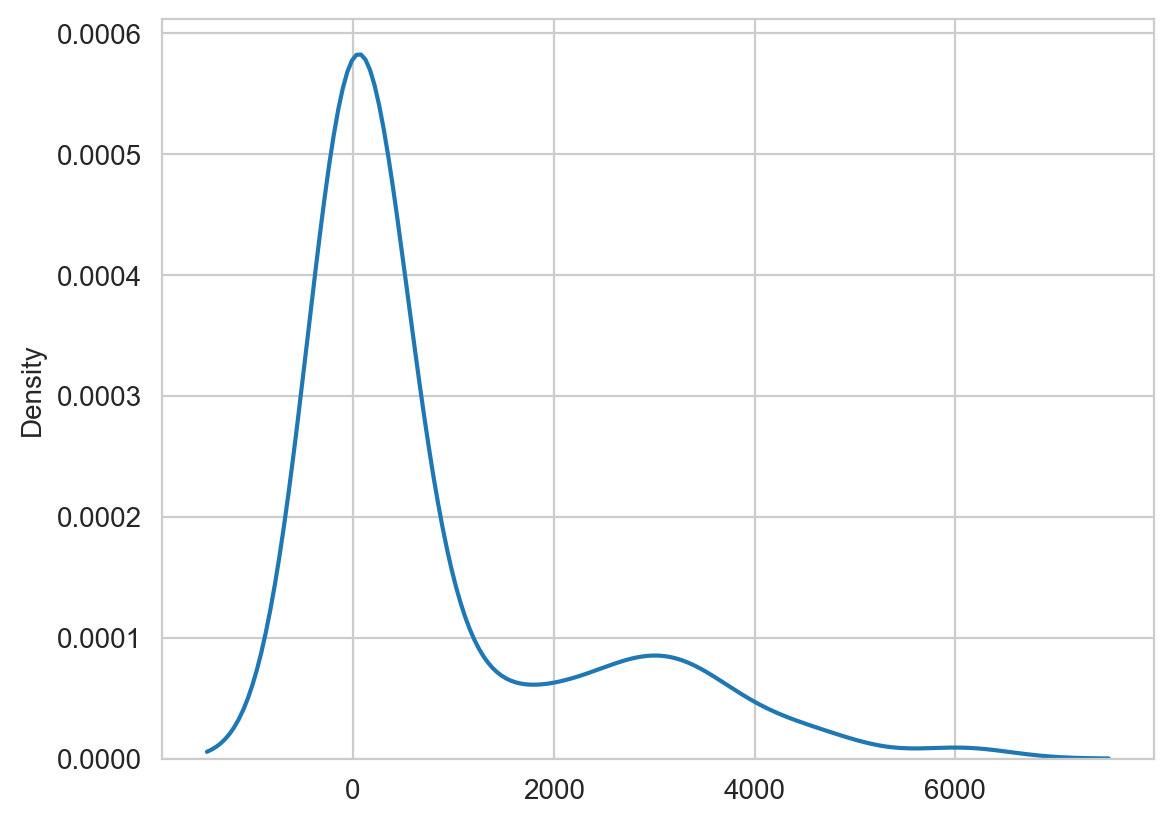

In [12]:
fig, ax = plt.subplots()
sns.kdeplot(np.concatenate(deriv_list), ax=ax)
#ax.set_xscale("log")

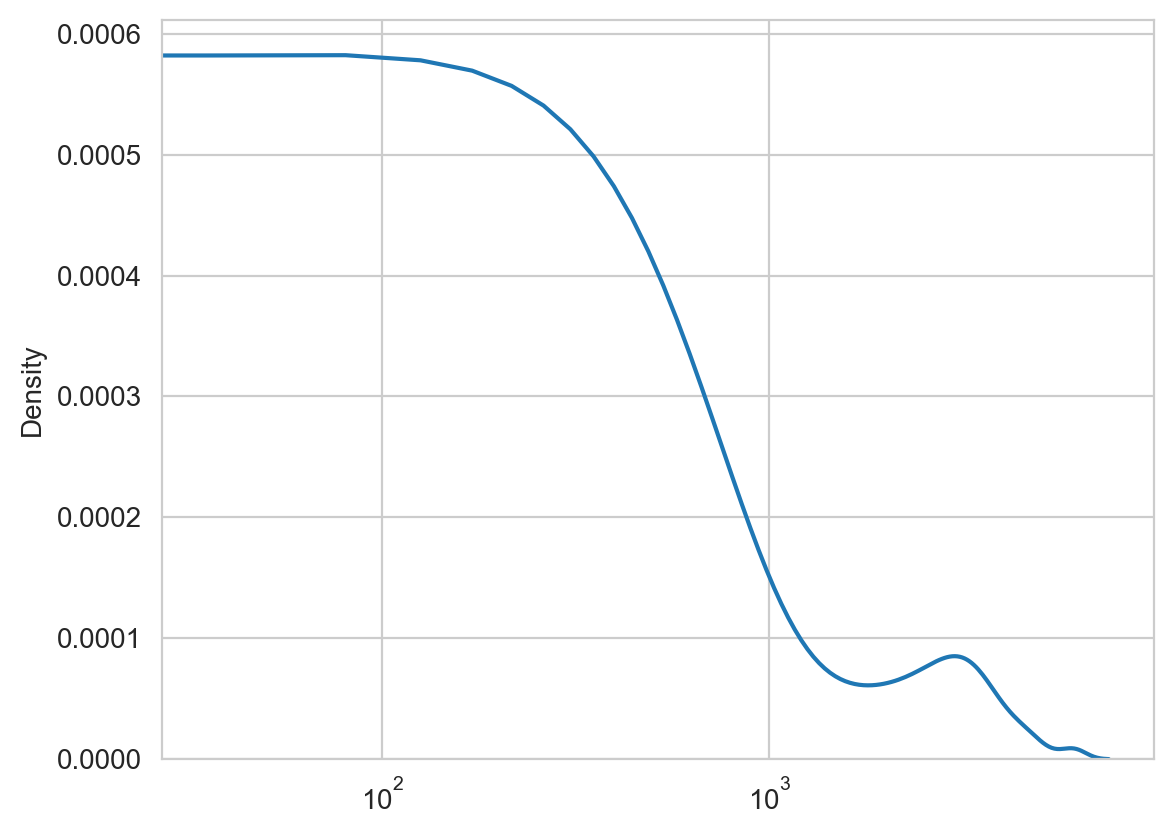

In [13]:
all_deriv = np.concatenate(deriv_list)
fig, ax = plt.subplots()
sns.kdeplot(all_deriv, ax=ax)
ax.set_xscale("log")

In [14]:
# max_vel = max([deriv.max() for deriv in deriv_list])
# print("max velocity", max_vel)
# min_vel = min([deriv.min() for deriv in deriv_list])
# range_vel = max_vel - min_vel

velocity = np.concatenate((np.zeros(1), np.logspace(-4, 4, 10)))
alpha_tvv = np.zeros((timestep.size, velocity.size, velocity.size))

bins = np.concatenate((velocity, np.full(1, np.inf)))

# print("bins", bins)

x = np.linspace(0, 1, 100)
for idx_day in range(n_days):

    deriv = deriv_list[idx_day]    
    deriv = np.clip(deriv, bins[0], bins[-1])
    v_indexes = np.digitize(deriv, bins, right=False) - 1
    
    n = len(v_indexes) - 1
    
    # density = hist / np.sum(hist)
    for t in range(n):
        # p = p_indexes[i]
        v = v_indexes[t]
        v_prime = v_indexes[t + 1]
        alpha_tvv[t, v, v_prime] += 1

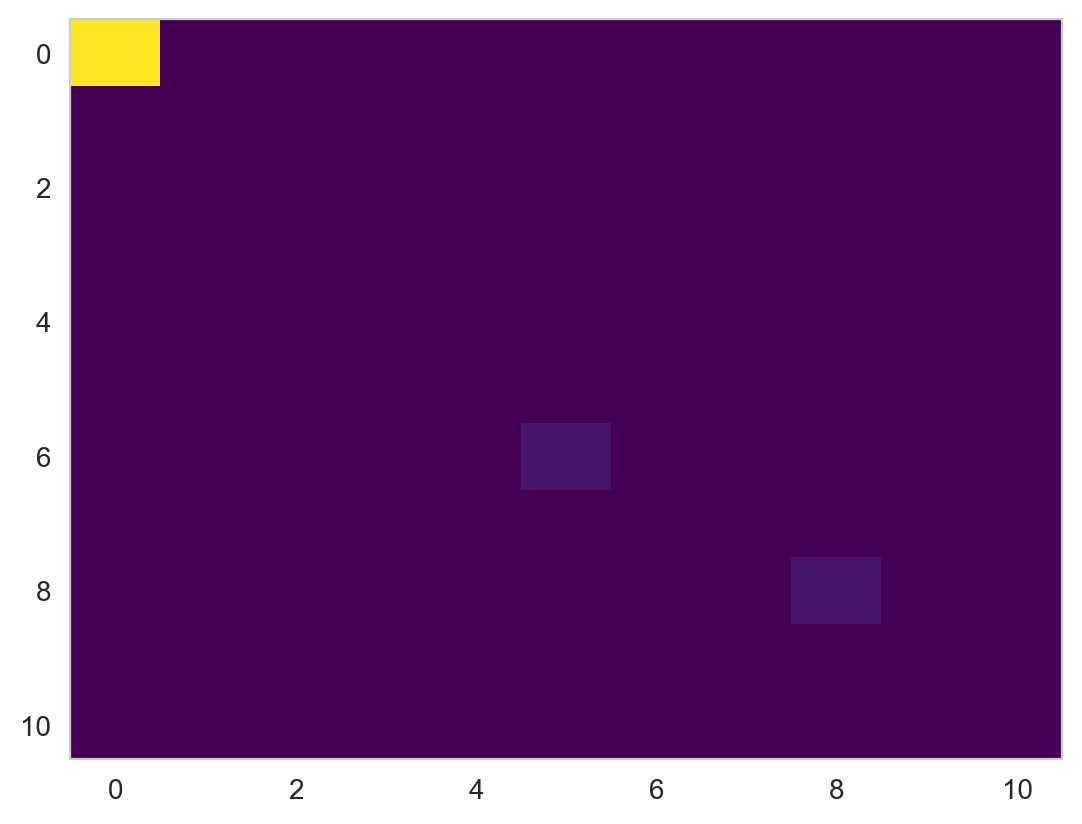

In [15]:
fig, ax = plt.subplots()
img = alpha_tvv[0, :, :]
ax.imshow(img, aspect="auto", cmap="viridis")
ax.grid(False)

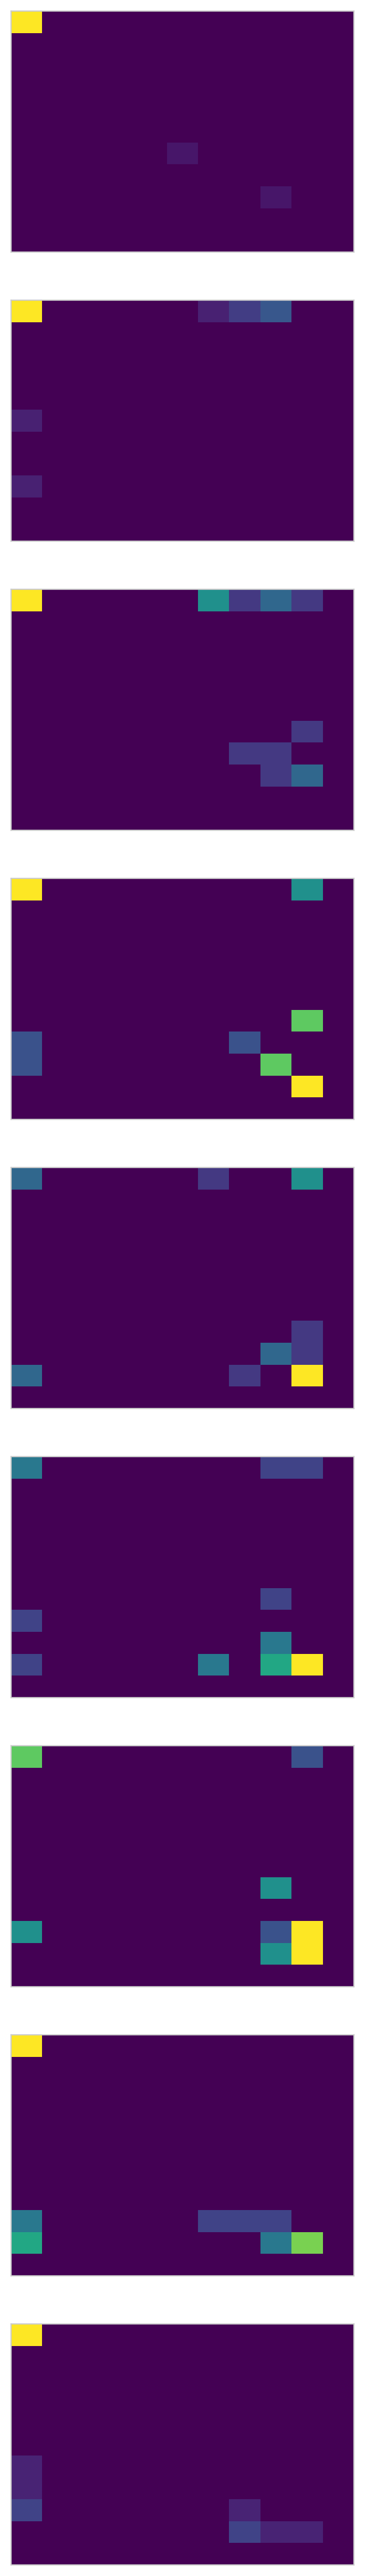

In [16]:
fig, axes = plt.subplots(
                nrows=timestep.size-1,  # Exclude last timestep
                figsize=(4, 3*timestep.size))
for t_idx in range(timestep.size-1):    # Exclude last timestep
    # for p_idx in range(n_position):
    ax = axes[t_idx]
    img = alpha_tvv[t_idx, :, :]
    ax.imshow(img, aspect="auto", cmap="viridis")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()

In [17]:
np.logspace(-4, 0, 5)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [18]:
np.geomspace(1e-4, 1, 5)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [19]:
img = np.arange(12).reshape(3, 4)

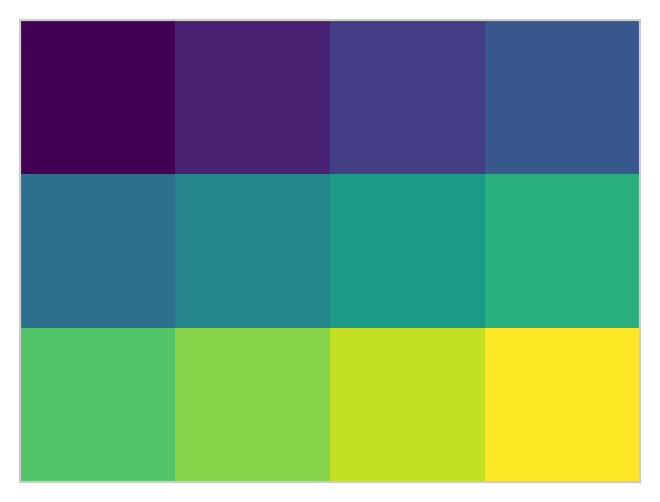

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(img, aspect="auto", cmap="viridis")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()

In [23]:
img

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])